In [1]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
from evaluation import evaluate
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def apply_evaluate(row, k):
#    return evaluate(row.recommendations.strip('[]').split(','), set(row.relevantItems.strip('[]').split(',')), k)
    e = evaluate(row.recommendations, set(row.relevantItems), k)
    return { 'precision': e.get('precision'), 'ndcg': e.get('ndcg') }

def evaluate_(recs, k):
    eval_cols = ('precision', 'ndcg')
    return recs.apply(lambda row: apply_evaluate(row, k), axis=1, result_type='expand').rename(columns={col: f'{col}-{k}' for col in eval_cols})

# Data Loading

In [2]:
dataset = 'letterboxd-200'

In [3]:
with open(f'dataset/{dataset}/{dataset}-network.jl') as f:
    records = [json.loads(line) for line in f]
network = pd.DataFrame.from_records(records).drop('created_at', axis=1, errors='ignore')
if dataset == 'mubi-200': # last hours to hand in the thesis :)
    network.follows = network.follows.astype(str)
    network.username = network.username.astype(str)

In [370]:
with open(f'dataset/{dataset}/{dataset}-users.jl') as f:
    test_users = {json.loads(line).get('username') for line in f}

In [371]:
with open(f'dataset/{dataset}/{dataset}-ratings.jl') as f:
    records = [json.loads(line) for line in f]
ratings = pd.DataFrame.from_records(records).dropna(subset=['rating']) #.sort_values(by='updated_at')
del records
ratings['rating'] = ratings['rating'].astype(int)

In [380]:
edge_weighting_strategies = ['Unary', 'CommonNeighbours', 'Jaccard', 'CosSim']
appleseed_combinations = [f'Appleseed-{strategy}' for strategy in edge_weighting_strategies]
global_rec_neighbour_comb = [f'{rec}-0' for rec in ['Random', 'GlobalTopPopular', 'LocalTopPopular']]
local_methods = ['RandomPeer', 'BFTrust', 'LocalUserBasedCF', 'CommonNeighbours', 'AdamicAdar', 'ResourceAllocation', *appleseed_combinations]
GLOBAL_BASELINE = 'GB'
LOCAL_BASELINE = 'LB'
LINK_PREDICTION = 'LP'
TRUST_PROPAGATION = 'TP'
HYBRID = 'H'
method_categories = {
    'Random': GLOBAL_BASELINE,
    'GlobalTopPopular': GLOBAL_BASELINE,
    
    'RandomPeer': LOCAL_BASELINE,
    'LocalTopPopular': LOCAL_BASELINE,
    'BFTrust': LOCAL_BASELINE,
    'LocalUserBasedCF': LOCAL_BASELINE,
    
    'CommonNeighbours': LINK_PREDICTION,
    'Jaccard': LINK_PREDICTION,
    'AdamicAdar': LINK_PREDICTION,
    'ResourceAllocation': LINK_PREDICTION,
    'UniformInformationPropagation': LINK_PREDICTION,
    
    'Appleseed': TRUST_PROPAGATION,
    
    'Ensemble': HYBRID
}
max_m_neighbours_list = [20, 100, 350, 1000]
local_rec_neighbour_comb = [f'{method}-{m_neighbour}' for method in local_methods for m_neighbour in max_m_neighbours_list]

In [381]:
recommendations = []
for method_neighbour in [*local_rec_neighbour_comb, *global_rec_neighbour_comb]:
    method_name, max_m_neighbours = method_neighbour.rsplit('-', 1)
    max_m_neighbours = int(max_m_neighbours)
    for fold in range(5):
        recs = pd.read_csv(f'evaluation/{dataset}/{method_neighbour}-{fold}-recommendations.csv')
        recs['method'] = method_name
        recs['max_m_neighbours'] = max_m_neighbours
        recs['fold'] = fold
        recommendations.append(recs)
        if max_m_neighbours == 0:
            # just so that we get a straight line in the lineplot for the methods that
            # don't change with respect to the max_m_neighbours
            for m_neighbours in max_m_neighbours_list:
                recs2 = recs.copy()
                recs2['max_m_neighbours'] = m_neighbours
                recommendations.append(recs2)
recommendations = pd.concat(recommendations)
recommendations['recommendations'] = recommendations.recommendations.apply(eval)
recommendations['testItems'] = recommendations.testItems.apply(eval)
recommendations['relevantItems'] = recommendations.relevantItems.apply(eval)
evaluations_with_folds = pd.concat([recommendations] + [evaluate_(recommendations, k) for k in (10, 45)], axis=1)
evaluations = evaluations_with_folds.groupby(['user', 'method', 'max_m_neighbours'], as_index=False).mean().drop('fold', axis=1)
evaluations['category'] = evaluations.method.apply(lambda method_name: method_categories.get(method_name.split('-')[0]))

# Evaluations

In [275]:
top_k = 10

In [438]:
def plot_recs_top_k(df, top_k, users_subset=None, save_filename=None):
    if users_subset is not None:
        df = df[df.user.isin(users_subset)]
    group_columns = ['method', 'max_m_neighbours', 'category']
    if 'fold' in df.columns:
        group_columns.append('fold')
    e_ndcg = df.groupby(by=group_columns, as_index=False).mean().sort_values(by=f'ndcg-{top_k}', ascending=False)
    plt.figure(figsize=(9,6))
    plot = sns.lineplot(data=e_ndcg, x='max_m_neighbours', y=f'ndcg-{top_k}', hue='method', style='category', markers=True, dashes=False, ci=None)
    plot.set_xscale('log')
    plot.set_xlabel('Max-m neighbors')
    plot.set_ylabel('NDCG@10')
    sns.despine()
    #plot.set_ylim([e_ndcg[f'ndcg-{top_k}'].min() - 0.01, e_ndcg[f'ndcg-{top_k}'].max() + 0.01])
    plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=2)
    if save_filename:
        plt.savefig(f'figures/{dataset}/{dataset}-{save_filename}.pdf', format="pdf", bbox_inches="tight")
    plt.show()

In [429]:
def make_presentable_table(evaluations, top_m, user_group, to_latex=False):
    def highlight_max(s):
        top_4 = s.sort_values(ascending=False).head(4)
        return np.where(s.isin(top_4.values), 'font-weight: bold', '')
    e = evaluations.groupby(['method', 'max_m_neighbours', 'category', 'user_group']).mean().sort_index(level=2).drop('user', axis=1, errors='ignore')
    # drop user, otherwise pandas keeps the average of the user ids when they are ints
    e_m = e.query(f'max_m_neighbours == {top_m}').droplevel(1)
    e_m = e_m.swaplevel(0,1)
    e_m.index.set_names(('Category', 'Method', 'User Group'), inplace=True)
    e_m = e_m.loc[(['GB', 'LB', 'LP', 'TP'],)] # to put them in an order
    e_m.rename(columns={col: col.replace('-', '@') for col in e_m.columns}, inplace=True)
    if to_latex:
        dataset_source = dataset.split("-")[0].capitalize()
        print(e_m.to_latex(bold_rows=True, float_format="%.3f", label=f'table:{dataset_source}-{user_group}-{top_m}', multirow=True, caption=f'{user_group}: top-10 and top-45 performance comparison using {top_m} neighbors ({dataset_source})'))
    else:
        return e_m.style.apply(highlight_max, axis=0)

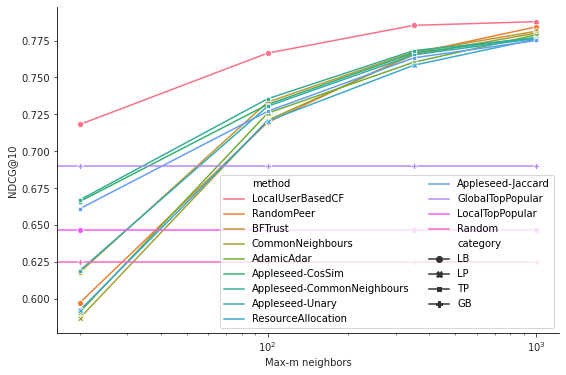

In [430]:
plot_recs_top_k(evaluations, top_k, save_filename='overall')

<AxesSubplot:xlabel='None-method2', ylabel='method1'>

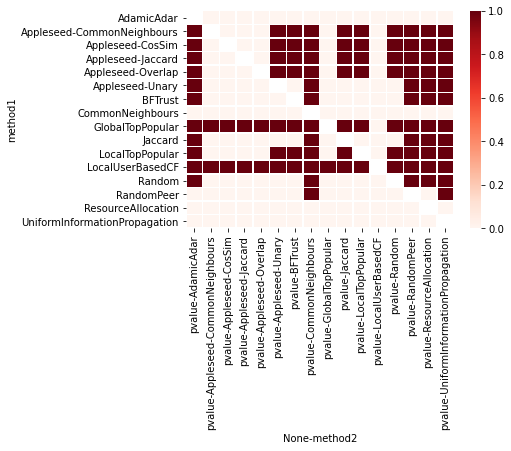

In [180]:
from itertools import permutations
from scipy.stats import ttest_ind
s = evaluations_with_folds[evaluations_with_folds.max_m_neighbours == 20].groupby(['method', 'fold']).mean()['ndcg-10']
ms = s.index.droplevel(1).unique().tolist()
pvalues = [{'method1': c1, 'method2': c2, 'pvalue': 1 - ttest_ind(s.loc[c1], s.loc[c2], equal_var=False, alternative='greater').pvalue} for c1, c2 in permutations(ms, 2)]
d = pd.DataFrame(pvalues)
d['pvalue'] = np.where(d.pvalue > 0.95, 1, 0)
sns.heatmap(d.pivot('method1', 'method2'), cmap=plt.cm.Reds, linewidths=0.5)

# User/item categorizations

In [263]:
num_ratings_threshold = 35

## Rating Related Cold-start Users

In [ ]:
rating_cold_start_users = ratings[ratings.username.isin(test_users)].groupby('username').filter(lambda df: len(df) < num_ratings_threshold).username.unique()
rating_cold_start_users

In [413]:
make_presentable_table(evaluations[evaluations.user.isin(rating_cold_start_users)], 100, 'Rating-based Cold-start', to_latex=False)

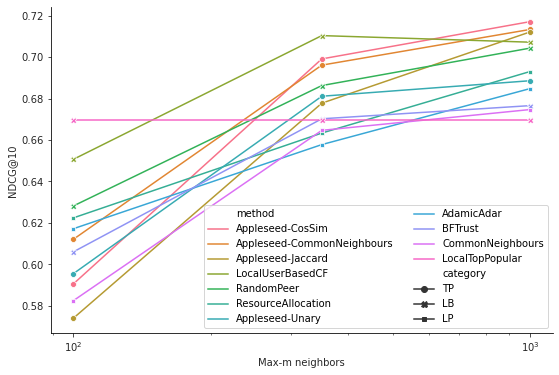

In [439]:
plot_recs_top_k(evaluations[(evaluations.max_m_neighbours > 20) & (~evaluations.method.isin(['Random', 'GlobalTopPopular']))], top_k, rating_cold_start_users, save_filename='rating-cold-start')

## Network Cold-start Users

In [ ]:
network_cold_start_users = network[network.username.isin(test_users)].groupby('username').count().query('follows < 8').index.values
network_cold_start_users

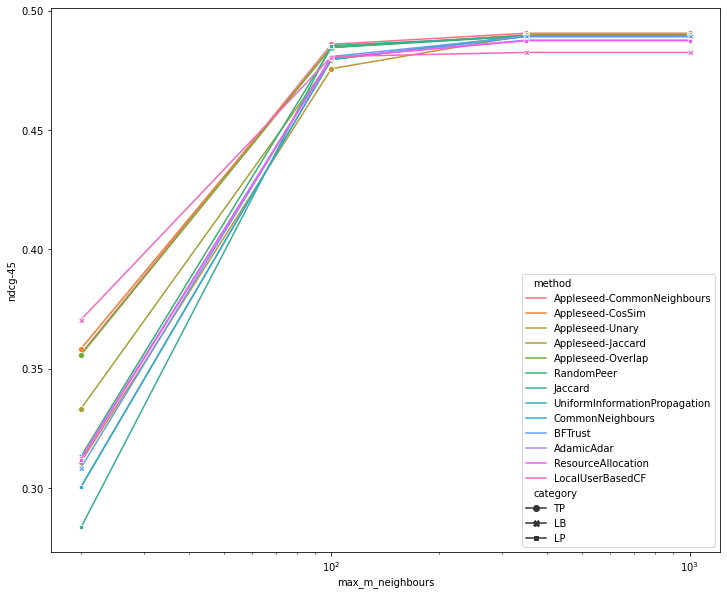

In [409]:
plot_recs_top_k(evaluations[(evaluations.category != 'GB')  & (evaluations.method != 'LocalTopPopular')], 45, network_cold_start_users, save_filename='network-cold-start-mubi')

In [414]:
make_presentable_table(evaluations[evaluations.user.isin(network_cold_start_users)], 100, 'Network-based Cold-start', to_latex=True)

\begin{table}
\centering
\caption{Network-based Cold-start: top-10 and top-45 performance comparison using 100 neighbors (Mubi)}
\label{table:Mubi-Network-based Cold-start-100}
\begin{tabular}{llrrrr}
\toprule
   &                 &  precision@10 &  ndcg@10 &  precision@45 &  ndcg@45 \\
\textbf{Category} & \textbf{Method} &               &          &               &          \\
\midrule
\multirow{2}{*}{\textbf{GB}} & \textbf{GlobalTopPopular} &         0.440 &    0.876 &         0.203 &    0.923 \\
   & \textbf{Random} &         0.400 &    0.830 &         0.208 &    0.911 \\
\cline{1-6}
\multirow{4}{*}{\textbf{LB}} & \textbf{BFTrust} &         0.301 &    0.538 &         0.086 &    0.481 \\
   & \textbf{LocalTopPopular} &         0.291 &    0.524 &         0.089 &    0.479 \\
   & \textbf{LocalUserBasedCF} &         0.300 &    0.534 &         0.088 &    0.481 \\
   & \textbf{RandomPeer} &         0.300 &    0.541 &         0.086 &    0.484 \\
\cline{1-6}
\multirow{5}{*}{\textbf{LP}} & \

In [442]:
items_stats = ratings[['film_id', 'rating']].groupby('film_id').agg(['mean', 'std', 'count'])
items_stats.columns = items_stats.columns.droplevel(level=0)

## Black-sheep Users

In [ ]:
ratings_stats = ratings[ratings.username.isin(test_users)].join(items_stats, on='film_id')
ratings_stats.loc[:, ('controversial')] = np.where((ratings_stats.rating - ratings_stats['mean']).abs() > ratings_stats['std'], 1, 0)
user_controversiality = ratings_stats.groupby('username').apply(lambda df: df.controversial.sum() / len(df) if len(df) >= num_ratings_threshold else 0) # users having few ratings may skew the data
black_sheep_users = user_controversiality[user_controversiality > 0.3].index.values
user_controversiality[user_controversiality > 0.3]

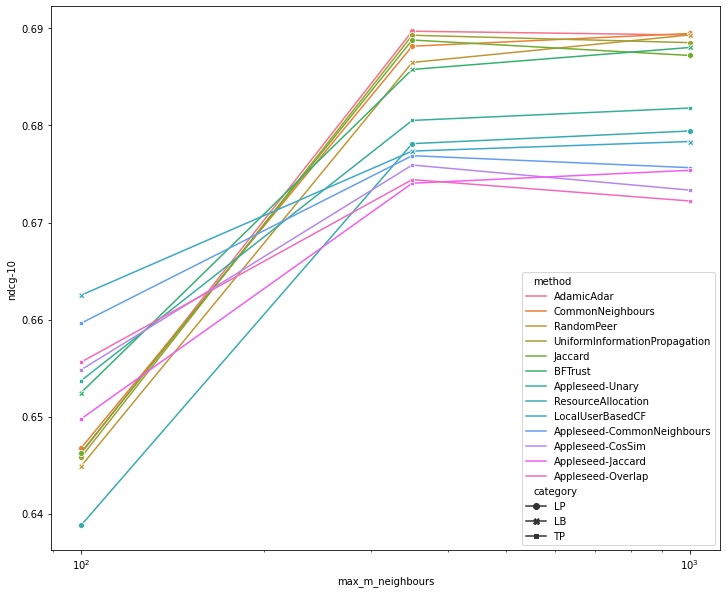

In [421]:
plot_recs_top_k(evaluations[(evaluations.category != 'GB') & (evaluations.method != 'LocalTopPopular') & (evaluations.max_m_neighbours > 20)], top_k, black_sheep_users, 'black-sheep')

In [440]:
make_presentable_table(evaluations[evaluations.user.isin(black_sheep_users)], 350, 'Black sheep', to_latex=False)

## Non-mainstream Users

In [ ]:
unpopular_items = items_stats.sort_values(by='count', ascending=False).iloc[len(items_stats) // 10:].index.values
unpopular_items

In [ ]:
non_mainstream_users = ratings[ratings.username.isin(test_users)].groupby('username').apply(lambda df: len(df[df.film_id.isin(unpopular_items)]) / len(df)).loc[lambda non_mainstreamness_score: non_mainstreamness_score > 0.25].index.values
non_mainstream_users

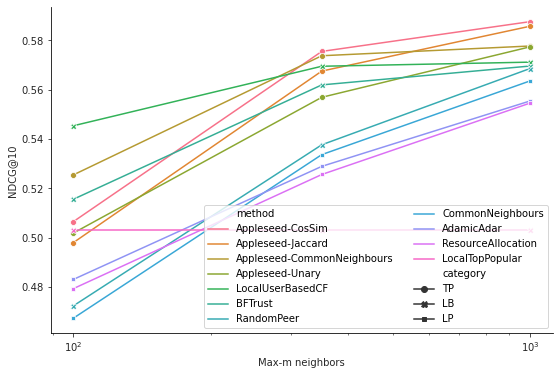

In [447]:
plot_recs_top_k(evaluations[(evaluations.max_m_neighbours > 20) & (~evaluations.method.isin(['Random', 'GlobalTopPopular']))], top_k, non_mainstream_users, 'non-mainstream')

In [455]:
make_presentable_table(evaluations[evaluations.user.isin(non_mainstream_users)], 350, 'Non-mainstream', to_latex=False)

## Opinionated Users

In [ ]:
ratings_std_count = ratings[['username', 'rating']].groupby('username').agg(['std', 'count'])
ratings_std_count.columns = ratings_std_count.columns.droplevel(level=0)
user_std_threshold = ratings_std_count[ratings_std_count['count'] >= num_ratings_threshold].describe().loc['75%', 'std']
print(f'User 75% std threshold: {user_std_threshold}')
opinionated_users = ratings_std_count[(ratings_std_count['count'] >= num_ratings_threshold) & (ratings_std_count['std'] > user_std_threshold)]
opinionated_users = opinionated_users[opinionated_users.index.isin(test_users)].index.values
opinionated_users

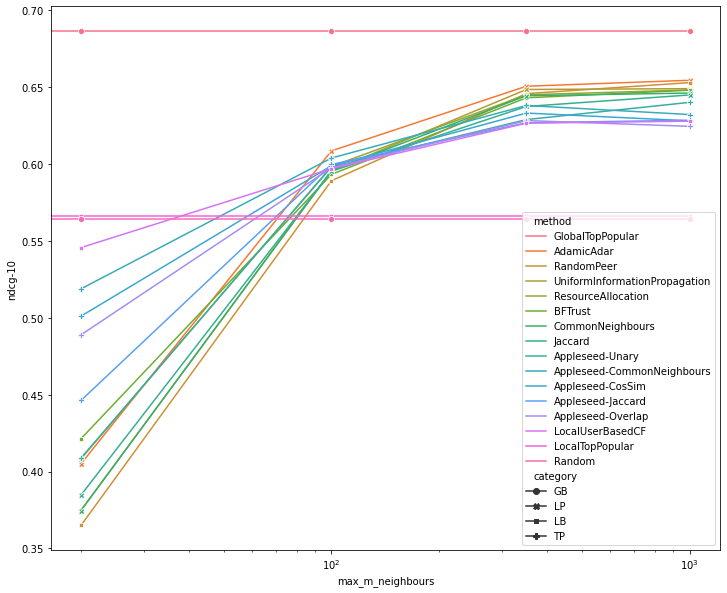

In [457]:
plot_recs_top_k(evaluations, top_k, opinionated_users, 'opinionated')

In [465]:
make_presentable_table(evaluations[evaluations.user.isin(opinionated_users)], 100, 'Opinionated', to_latex=False)

## Num users in groups

In [301]:
print('Core:', len(test_users))
print('Rating cold-start:', len(rating_cold_start_users))
print('Network cold-start:', len(network_cold_start_users))
print('Black sheep:', len(black_sheep_users))
print('Non-mainstream:', len(non_mainstream_users))
print('Opinionated:', len(opinionated_users))

Core: 200
Rating cold-start: 46
Network cold-start: 88
Black sheep: 44
Non-mainstream: 71
Opinionated: 23


## One Bar Plot per recommender for ndcg@10 for different bars per user group 

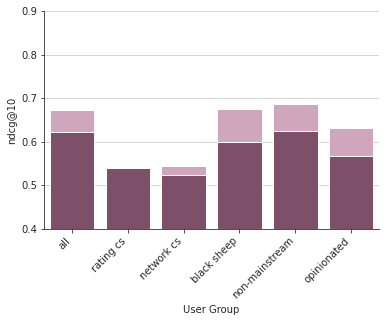

In [302]:
user_groups = {
    'rating cs': rating_cold_start_users,
    'network cs': network_cold_start_users,
    'black sheep': black_sheep_users,
    'non-mainstream': non_mainstream_users,
    'opinionated': opinionated_users
}
evaluations_with_user_groups = [evaluations.assign(user_group='all')]
for ug, users in user_groups.items():
    evaluations_with_user_groups.append(evaluations[evaluations.user.isin(users)].assign(user_group=ug))
df_ug = make_presentable_table(pd.concat(evaluations_with_user_groups), 1000, 'all', to_latex=False).data.reset_index()
_methods = df_ug['Method'].unique()
with sns.axes_style('ticks', {'axes.grid': True}):
    fig, ax = plt.subplots()
    #ax = sns.barplot(data=df_ug[df_ug['Method'].isin(['LocalTopPopular', 'Appleseed-CommonNeighbours'])], x='User Group', y='ndcg@10', hue='Method', order=['all', *user_groups.keys()], dodge=False)
    ax = sns.barplot(data=df_ug[df_ug['Method'].isin(['Appleseed-CommonNeighbours'])], x='User Group', y='ndcg@10', order=['all', *user_groups.keys()], color='#D79FBD')
    ax = sns.barplot(data=df_ug[df_ug['Method'].isin(['LocalTopPopular'])], x='User Group', y='ndcg@10', order=['all', *user_groups.keys()], color='#864769')
    ax.set_ylim([0.4, 0.9])
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    #for idx, method in enumerate(['Appleseed-CommonNeighbours', 'GlobalTopPopular']):
    #    ax = sns.barplot(data=df_ug[df_ug['Method'] == method], x='User Group', y='ndcg@10', order=['all', *user_groups.keys()])
    #    plot.set_ylim([0.4, 1])
    #    plt.xticks(rotation=45, ha='right')
    #    plt.savefig(f'figures/{dataset}/{dataset}-{method}-top-10-user-groups.pdf', format="pdf", bbox_inches="tight")
    plt.savefig(f'figures/{dataset}/{dataset}-appleseed-gains.pdf', format="pdf", bbox_inches="tight")

    plt.show()

In [ ]:
recommendations[(recommendations.user == '') & (recommendations.method.isin(['BFTrust', 'CommonNeighbours'])) & (recommendations.max_m_neighbours == 100) & (recommendations.fold == 0)]

In [ ]:
user_groups = {
    'rating cs': rating_cold_start_users,
    'network cs': network_cold_start_users,
    'black sheep': black_sheep_users,
    'non-mainstream': non_mainstream_users,
    'opinionated': opinionated_users
}
evaluations_with_user_groups = []
for ug, users in user_groups.items():
    evaluations_with_user_groups.append(evaluations[evaluations.user.isin(users)].assign(user_group=ug))
df_ug = make_presentable_table(pd.concat(evaluations_with_user_groups), 100, 'all', to_latex=False).data.reset_index()
sns.catplot(data=df_ug, x='User Group', y='ndcg@10', row='Method', kind='bar', )

## Controversial Items

In [381]:
items_std_threshold = items_stats[items_stats['count'] >= num_ratings_threshold].describe().loc['75%', 'std']
print(f'Item 75% std threshold: {items_std_threshold}')
controversial_items = items_stats[(items_stats['count'] >= num_ratings_threshold) & (items_stats['std'] > items_std_threshold)]
controversial_items = set(controversial_items.index.astype(int).values)

Item 75% std threshold: 1.9273702162662842


In [390]:
controversial_recommendations = recommendations.copy()
controversial_recommendations['recommendations'] = controversial_recommendations.recommendations.apply(lambda items: [item for item in items if item in controversial_items])
controversial_recommendations['testItems'] = controversial_recommendations.testItems.apply(lambda items: [item for item in items if item in controversial_items])
controversial_recommendations['relevantItems'] = controversial_recommendations.relevantItems.apply(lambda items: [item for item in items if item in controversial_items])
controversial_recommendations = controversial_recommendations[controversial_recommendations.relevantItems.astype(bool)]
controversial_evaluations = pd.concat([controversial_recommendations] + [evaluate_(controversial_recommendations, k) for k in (10, 50, 100)], axis=1)
controversial_evaluations['category'] = controversial_evaluations.method.apply(lambda method_name: method_categories.get(method_name.split('-')[0]))

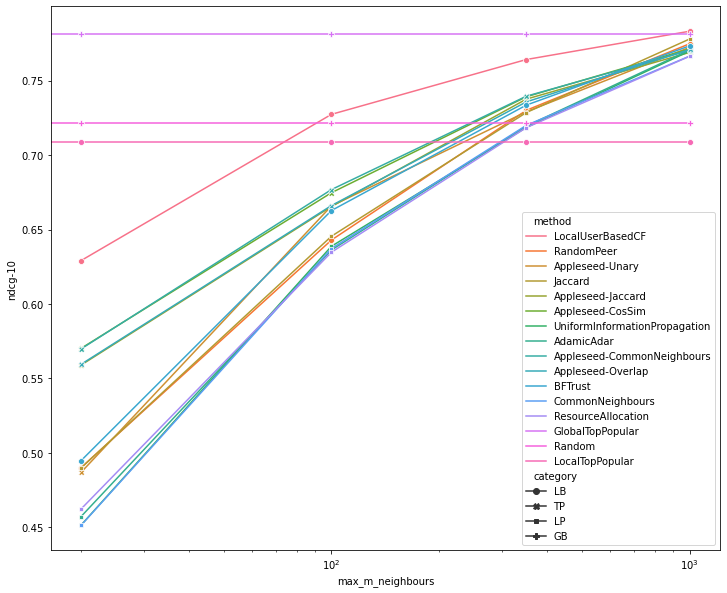

In [391]:
plot_recs_top_k(controversial_evaluations, top_k, save_filename='controversial-items-letterboxd')

# Degree distribution

In [306]:
out_degrees = network.groupby('username').count()
out_degrees = out_degrees[out_degrees.index.isin(test_users)]

In [ ]:
out_degrees

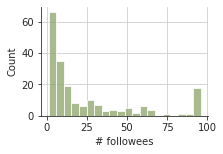

In [334]:
with sns.axes_style('ticks', {'axes.grid': True}):
    plt.figure(figsize=(3,2))
    plot = sns.histplot(out_degrees, bins=20, palette=['#8CA569'], legend=False)
    sns.despine()
    plot.set_xlabel('# followees')
    plt.savefig(f'figures/{dataset}/{dataset}-followee-hist.pdf', format="pdf", bbox_inches="tight")

# 2-Hop Neighbourhood

In [327]:
out_degrees_2_hop = network[network.username.isin(test_users)].merge(network, left_on='follows', right_on='username').rename(columns={'username_x': 'username', 'follows_y': 'follows_2_hop'})
out_degrees_2_hop = out_degrees_2_hop[out_degrees_2_hop.username != out_degrees_2_hop.follows_2_hop]
out_degrees_2_hop = out_degrees_2_hop[~out_degrees_2_hop.duplicated(['username', 'follows_2_hop'], keep='last')]
out_degrees_2_hop = out_degrees_2_hop[['username', 'follows_2_hop']].groupby('username').count()

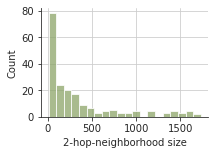

In [336]:
with sns.axes_style('ticks', {'axes.grid': True}):
    plt.figure(figsize=(3,2))
    plot = sns.histplot(out_degrees_2_hop, bins=20, palette=['#8CA569'], legend=False)
    sns.despine()
    plot.set_xlabel('2-hop-neighborhood size')
    #plt.xticks([0,500,1000,1500,2000])
    plt.savefig(f'figures/{dataset}/{dataset}-followee-2-hist.pdf', format="pdf", bbox_inches="tight")

# Rating Distribution

In [329]:
ratings_dist = ratings.groupby('username').count()['film_id']
ratings_test_users_dist = ratings[ratings.username.isin(test_users)].groupby('username').count()['film_id']

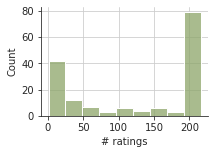

In [337]:
with sns.axes_style('ticks', {'axes.grid': True}):
    plt.figure(figsize=(3,2))
    # for series, sns uses color
    # for dfs, palette
    plot = sns.histplot(ratings_test_users_dist, color=['#8CA569'], legend=False)
    sns.despine()
    plot.set_xlabel('# ratings')
    plt.savefig(f'figures/{dataset}/{dataset}-ratings-hist-core.pdf', format="pdf", bbox_inches="tight")

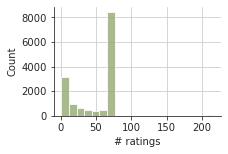

In [338]:
with sns.axes_style('ticks', {'axes.grid': True}):
    plt.figure(figsize=(3,2))
    # for series, sns uses color
    # for dfs, palette
    plot = sns.histplot(ratings_dist, color=['#8CA569'], legend=False, bins=20)
    sns.despine()
    plot.set_xlabel('# ratings')
    plt.savefig(f'figures/{dataset}/{dataset}-ratings-hist-all.pdf', format="pdf", bbox_inches="tight")

# Statistics

In [374]:
network[~network.username.isin(test_users)].groupby('username').count().describe()

follows
count  7359.000000
mean     21.991575
std       6.636358
min       1.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      25.000000

In [372]:
hop1 = network[network.username.isin(test_users)].follows.unique()

In [376]:
noncore = network[~network.follows.isin(test_users)].follows.unique()

In [377]:
len(noncore)

63648

In [379]:
ratings[~ratings.username.isin(test_users)].groupby('username').count().describe()

film_id     film_link        rating
count  59898.000000  59898.000000  59898.000000
mean      55.236886     55.236886     55.236886
std       21.400976     21.400976     21.400976
min        1.000000      1.000000      1.000000
25%       45.000000     45.000000     45.000000
50%       66.000000     66.000000     66.000000
75%       72.000000     72.000000     72.000000
max       72.000000     72.000000     72.000000

# Evaluation per degree distribution

In [31]:
with open('dataset/letterboxd-spinozism-500/ratings-folds/train-0.jl') as f:
    records = [json.loads(line) for line in f]
ratings = pd.DataFrame.from_records(records).dropna(subset=['rating']) #.sort_values(by='updated_at')
del records
ratings = ratings[ratings.username.isin(test_users)]
ratings = ratings[~ratings.duplicated(['username', 'film_id'], keep='last')]

In [32]:
in_degrees_max = in_degrees.username.max()
out_degrees_max = out_degrees.follows.max()
num_ratings = ratings[['username', 'rating']].groupby('username').count()
num_ratings_max = num_ratings.rating.max()

In [ ]:
in_degrees

In [34]:
# we need normalization if we want to use PCA, but computing the correlation matrix already takes care of it, so we don't need normalization
evaluation_with_features = evaluations.set_index('user')[['ndcg-10', 'method']].join([in_degrees, out_degrees, out_degrees_2_hop, num_ratings]).fillna(0)

In [60]:
evaluation_with_features['rating_binned'] = pd.qcut(evaluation_with_features.rating, q=10, duplicates='drop').cat.codes
evaluation_with_features['follows_binned'] = pd.qcut(evaluation_with_features.follows, q=10, duplicates='drop').cat.codes
evaluation_with_features['follows_2_hop_binned'] = pd.qcut(evaluation_with_features.follows_2_hop, q=10, duplicates='drop').cat.codes

In [ ]:
pd.qcut(evaluation_with_features.follows_2_hop, q=10, duplicates='drop')

<AxesSubplot:title={'center':'ndcg-10'}, xlabel='follows_2_hop_binned'>

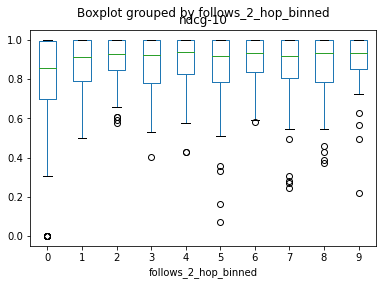

In [63]:
evaluation_with_features.boxplot(column='ndcg-10', by='follows_2_hop_binned', grid=False)

<AxesSubplot:xlabel='follows_binned', ylabel='ndcg-10'>

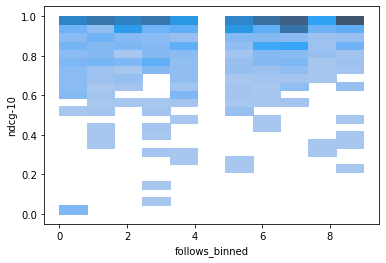

In [68]:
sns.histplot(data=evaluation_with_features, x='follows_binned', y='ndcg-10')

<AxesSubplot:xlabel='follows_2_hop_binned', ylabel='ndcg-10'>

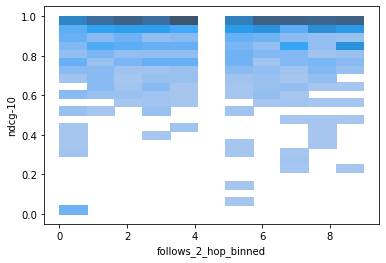

In [84]:
sns.histplot(data=evaluation_with_features, x='follows_2_hop_binned', y='ndcg-10')

<AxesSubplot:xlabel='follows_2_hop', ylabel='rating'>

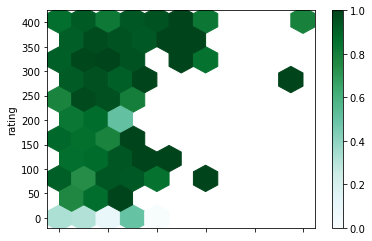

In [15]:
evaluation_with_features.plot.hexbin(x='follows_2_hop', y='rating', C='ndcg-5', gridsize=10)

<AxesSubplot:title={'center':'ndcg-5'}, xlabel='rating_binned'>

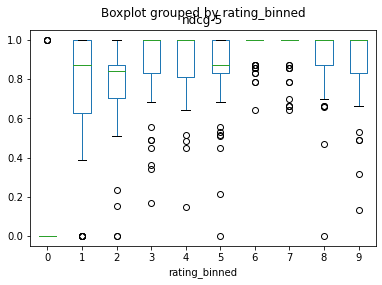

In [25]:
evaluation_with_features.boxplot(column='ndcg-5', by='rating_binned', grid=False)

In [33]:
from scipy.stats import ttest_1samp
ttest_1samp(evaluation_with_features[evaluation_with_features.follows >= 10]['ndcg-5'], evaluation_with_features[(evaluation_with_features.follows < 10) & (evaluation_with_features.follows > 0)]['ndcg-5'].mean())

Ttest_1sampResult(statistic=7.729914110552508, pvalue=7.95337695937379e-14)

<AxesSubplot:>

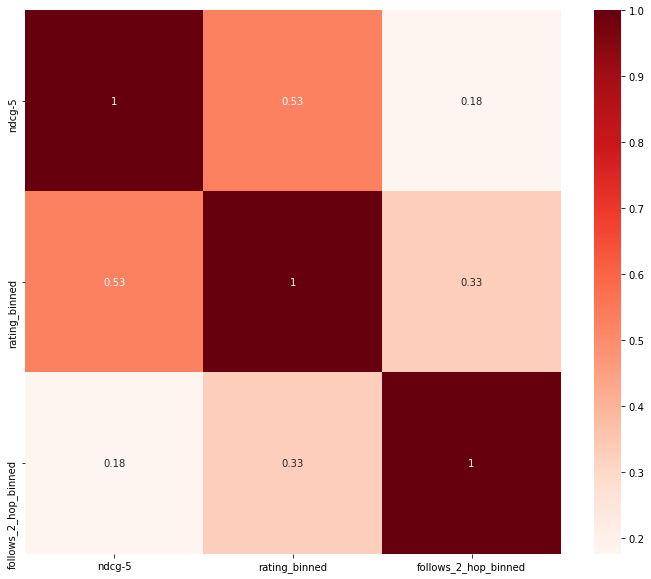

In [40]:
plt.figure(figsize=(12,10))
cor = evaluation_with_features.drop(columns=['precision-5', 'username', 'follows', 'follows_2_hop', 'rating', 'follows_binned']).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

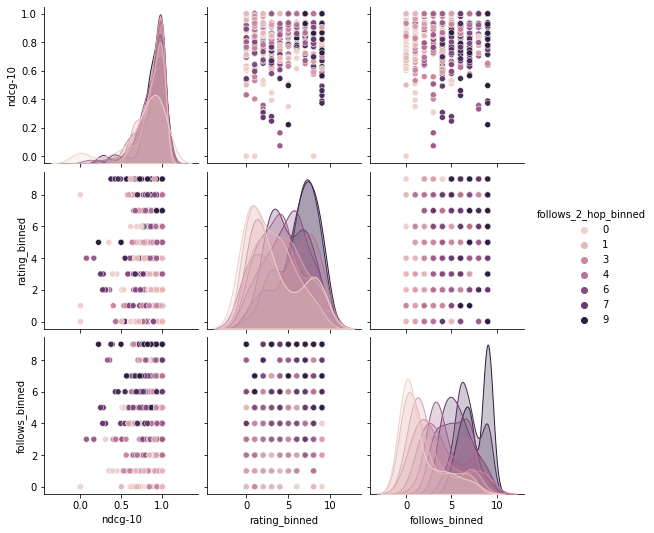

In [18]:
sns.pairplot(evaluation_with_features.drop(columns=['username', 'follows', 'follows_2_hop', 'rating']), hue='follows_2_hop_binned')

<AxesSubplot:ylabel='Frequency'>

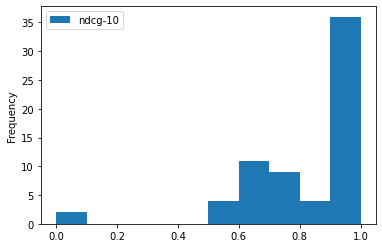

In [30]:
evaluation_with_features[evaluation_with_features.rating < 25][['method', 'ndcg-10']]

In [ ]:
a = out_degrees_2_hop.reset_index()
a[(a.follows_2_hop > 0) & (a.follows_2_hop < 200) & a.username.isin(test_users)]

In [8]:
import networkx as nx
usr = ''
foo = network[network.username == usr].follows
df = network[network.username.isin(foo.tolist() + [usr])]
g = nx.convert_matrix.from_pandas_edgelist(df, source='username', target='follows')
pos = nx.kamada_kawai_layout(g)

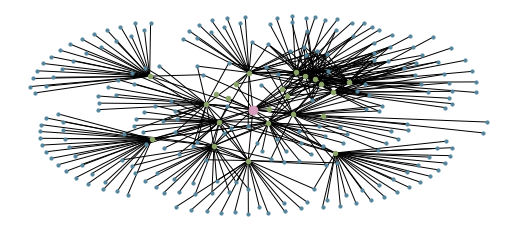

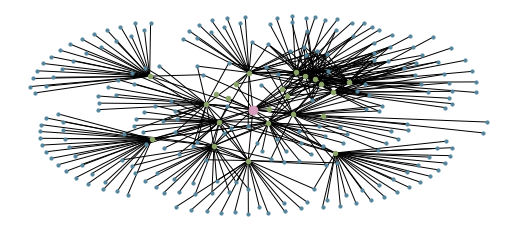

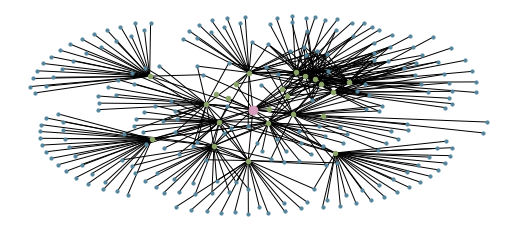

In [9]:
m = 0
for method in ['CommonNeighbours', 'Appleseed-Jaccard', 'LocalUserBasedCF']:
    fig = plt.figure(figsize=(9,4))
    plot = fig.add_subplot()
    #usr_top_neighbors = recommendations[(recommendations.user == usr) & (recommendations.method == method)].neighbourhood.values[0]
    #usr_top_neighbors = usr_top_neighbors.strip('[]').split(',')[:m]
    nx.draw(g, pos=pos, node_size=10, node_color="#56869D")
    nx.draw_networkx_nodes(g, pos=pos, nodelist=foo.values, node_size=20, node_color="#8CA569")
    #for idx, neighbor in enumerate(usr_top_neighbors):
        #node_color = "#8CA569" if neighbor in foo.values else "#56869D"
        #nx.draw_networkx_nodes(g, pos=pos, nodelist=[neighbor], node_size=420-(350/m)*idx, node_color=node_color)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=[usr], node_size=80, node_color="#D79FBD")
    plot.set_xlabel(method)
    plt.savefig(f'figures/{dataset}/{dataset}-networkx-{method}.pdf', format="pdf", bbox_inches="tight")
    plt.show()